In [1]:
#Importing libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
from numpy import asarray
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime
from statsmodels.tsa.tsatools import lagmat
from statsmodels.tsa.arima.model import ARIMA
from pandas import concat


# Data Import and Cleaning

In [2]:
%store -r df_cleaned
df = df_cleaned 

In [3]:
TS1 = df[(df['Plz'] == "['25', '24']")]
TS1_A2 = TS1[TS1['full'] == 'A2 -  geschreddert']
TS1_A1A2 = TS1[TS1['full'] == 'A1 & A2 -  geschreddert']
TS1_A2A3 = TS1[TS1['full'] == 'A2 & A3 -  geschreddert']

# Modelling - Train, test split

# Random Forest

In [4]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 n_vars = 1 if type(data) is list else data.shape[1]
 df = pd.DataFrame(data)
 cols = list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
    cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
# drop rows with NaN values
 if dropnan:
    agg.dropna(inplace=True)
 return agg.values

In [5]:
X = TS1_A1A2["wPreis"].values.reshape(-1, 1)


In [6]:
rf_data = series_to_supervised(X, n_in=4)

In [7]:

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
 return data[:-n_test, :], data[-n_test:, :]

### Walk-forward validation

In [8]:
from sklearn.ensemble import RandomForestRegressor

In [9]:
# walk-forward validation for univariate data
def rf_walk_forward_validation(data, n_test):
 predictions = list()
 direction_accuracies = list() 
 # split dataset
 train, test = train_test_split(data, n_test)
 # seed history with training dataset
 history = [x for x in train]
 # step over each time-step in the test set
 for i in range(len(test)):
    # split test row into input and output columns
    testX, testy = test[i, :-1], test[i, -1]
    # fit model on history and make a prediction
    yhat = random_forest_forecast(history, testX)
    # store forecast in list of predictions
    predictions.append(yhat)
    if i > 0:  # Direction accuracy is not applicable for the first prediction
            forecast_diff = yhat - predictions[-2]
            actual_diff = testy - test[i - 1, -1]
            direction_accuracy = int(np.sign(forecast_diff) == np.sign(actual_diff))
            direction_accuracies.append(direction_accuracy)
    # add actual observation to history for the next loop
    history.append(test[i])
    # summarize progress
    print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
 # estimate prediction error
 error = mean_absolute_error(test[:, -1], predictions)
 me = np.mean(predictions - test[:, -1])  # Mean Error
 rmse = mean_squared_error(test[:, -1], predictions, squared=False)
 overall_direction_accuracy = np.mean(direction_accuracies)

 return error, me, rmse ,test[:, -1], predictions, overall_direction_accuracy 

In [10]:
# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
 # transform list into array
 train = asarray(train)
 # split into input and output columns
 trainX, trainy = train[:, :-1], train[:, -1]
 # fit model
 model = RandomForestRegressor(n_estimators=1000, random_state=42)
 model.fit(trainX, trainy)
 # make a one-step prediction
 yhat = model.predict([testX])
 return yhat[0]

>expected=21.8, predicted=8.1
>expected=5.4, predicted=15.3
>expected=-2.3, predicted=11.3
>expected=1.8, predicted=3.4
>expected=5.5, predicted=7.1
>expected=11.0, predicted=8.3
MAE: 7.166
ME: 1.723
RMSE: 8.955
Direction Accuracy: 0.600


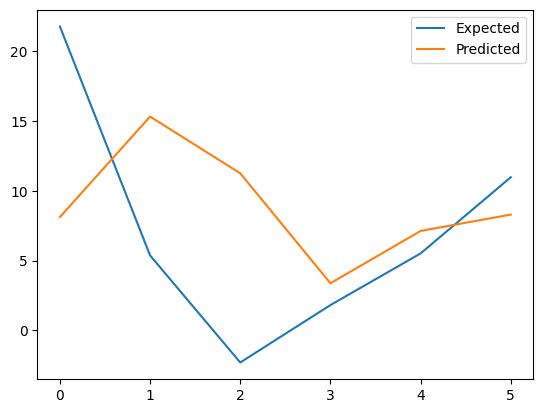

In [11]:
# evaluate
mae, me, rmse, y, yhat, direction_accuracy = rf_walk_forward_validation(rf_data, 6)
print('MAE: %.3f' % mae)
print('ME: %.3f' % me)
print('RMSE: %.3f' % rmse)
print('Direction Accuracy: %.3f' % direction_accuracy)
# plot expected vs preducted
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()

In [12]:
results = {
    'mae': [mae],
    'me': [me],
    'rmse': [rmse],
    'direction_accuracy': [direction_accuracy]
}

# Convert the dictionary into a DataFrame
RandomForest_wf = pd.DataFrame(results)
RandomForest_wf

,mae,me,rmse,direction_accuracy
0,7.165923,1.722831,8.955055,0.6


In [13]:
%store RandomForest_wf

Stored 'RandomForest_wf' (DataFrame)


### Rolling forecast for Random Forest  

Since this method uses 4 lagged values as input for predicting the next step, we are exposing the test data set in every iteration. So essentially this is a forecast with a window of "input" moving along the test set, predicting one step at a time, but having been trained on the original training set only once.

In [14]:
train, test = train_test_split(rf_data, 6)


In [15]:
test

array([[19.08385688, 22.15590367, 14.05657364,  5.70419682, 21.77178067],
       [22.15590367, 14.05657364,  5.70419682, 21.77178067,  5.37221127],
       [14.05657364,  5.70419682, 21.77178067,  5.37221127, -2.29737704],
       [ 5.70419682, 21.77178067,  5.37221127, -2.29737704,  1.8152799 ],
       [21.77178067,  5.37221127, -2.29737704,  1.8152799 ,  5.51596431],
       [ 5.37221127, -2.29737704,  1.8152799 ,  5.51596431, 10.97189655]])

In [16]:
train = asarray(train)

In [17]:
trainX, trainy = train[:, :-1], train[:, -1]


In [18]:
model_rf_rolling = RandomForestRegressor(n_estimators=1000, random_state=42)
model_rf_rolling.fit(trainX, trainy)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [19]:
predictions = list()
direction_accuracies = list() 

In [20]:
for i in range(len(test)):
    print(test[i, :-1])

[19.08385688 22.15590367 14.05657364  5.70419682]
[22.15590367 14.05657364  5.70419682 21.77178067]
[14.05657364  5.70419682 21.77178067  5.37221127]
[ 5.70419682 21.77178067  5.37221127 -2.29737704]
[21.77178067  5.37221127 -2.29737704  1.8152799 ]
[ 5.37221127 -2.29737704  1.8152799   5.51596431]


In [21]:
test

array([[19.08385688, 22.15590367, 14.05657364,  5.70419682, 21.77178067],
       [22.15590367, 14.05657364,  5.70419682, 21.77178067,  5.37221127],
       [14.05657364,  5.70419682, 21.77178067,  5.37221127, -2.29737704],
       [ 5.70419682, 21.77178067,  5.37221127, -2.29737704,  1.8152799 ],
       [21.77178067,  5.37221127, -2.29737704,  1.8152799 ,  5.51596431],
       [ 5.37221127, -2.29737704,  1.8152799 ,  5.51596431, 10.97189655]])

In [22]:
for i in range(len(test)):
    # split test row into input and output columns
    testX, testy = test[i, :-1], test[i, -1]
    # ONLY MAKE ONE-STEP PREDICTIONS BASED ON MODEL TRAINED ONCE 
    print(testX)
    yhat = model_rf_rolling.predict([testX])
    # store forecast in list of predictions
    predictions.append(yhat)
    if i > 0:  # Direction accuracy is not applicable for the first prediction
            forecast_diff = yhat - predictions[-2]
            actual_diff = testy - test[i - 1, -1]
            direction_accuracy = int(np.sign(forecast_diff) == np.sign(actual_diff))
            direction_accuracies.append(direction_accuracy)
    # summarize progress
    print('>expected=%.1f, predicted=%.1f' % (testy, yhat))


[19.08385688 22.15590367 14.05657364  5.70419682]
>expected=21.8, predicted=8.1
[22.15590367 14.05657364  5.70419682 21.77178067]
>expected=5.4, predicted=17.8
[14.05657364  5.70419682 21.77178067  5.37221127]
>expected=-2.3, predicted=7.7
[ 5.70419682 21.77178067  5.37221127 -2.29737704]
>expected=1.8, predicted=2.4
[21.77178067  5.37221127 -2.29737704  1.8152799 ]
>expected=5.5, predicted=6.3
[ 5.37221127 -2.29737704  1.8152799   5.51596431]
>expected=11.0, predicted=8.9


In [23]:
yhat

array([8.85532956])

In [24]:
predictions

[array([8.11715881]),
 array([17.78329699]),
 array([7.66090241]),
 array([2.42595934]),
 array([6.29435285]),
 array([8.85532956])]

In [25]:
mae = mean_absolute_error(test[:, -1], predictions)
me = np.mean(predictions - test[:, -1])  # Mean Error
rmse = mean_squared_error(test[:, -1], predictions, squared=False)
overall_direction_accuracy = np.mean(direction_accuracies)

#return error, me, rmse ,test[:, -1], predictions, overall_direction_accuracy 

Forecast accuracy for Rolling Forecast with Random Forest
MAE: 6.588
ME: 1.331
RMSE: 8.613
Direction Accuracy: 0.600


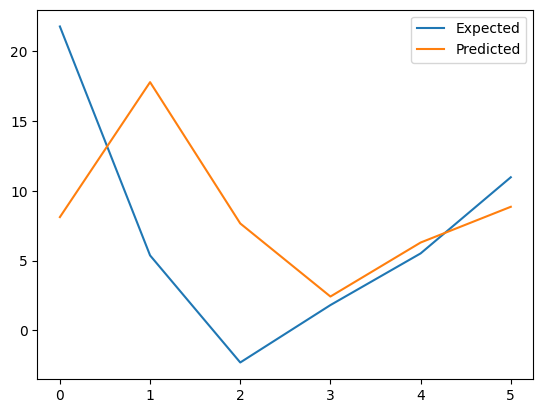

In [26]:
#print('MAE: %.3f' % mae)
print('Forecast accuracy for Rolling Forecast with Random Forest')
print('MAE: %.3f' % mae)
print('ME: %.3f' % me)
print('RMSE: %.3f' % rmse)
print('Direction Accuracy: %.3f' % overall_direction_accuracy)
# plot expected vs preducted
plt.plot(y, label='Expected')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

In [27]:
roll_results = {
    'mae': [mae],
    'me': [me],
    'rmse': [rmse],
    'direction_accuracy': [overall_direction_accuracy]
}

# Convert the dictionary into a DataFrame
RandomForest_roll = pd.DataFrame(roll_results)
RandomForest_roll

,mae,me,rmse,direction_accuracy
0,6.58827,1.331207,8.613069,0.6


In [28]:
%store RandomForest_roll


Stored 'RandomForest_roll' (DataFrame)


## Static (Multi-step) Forecast

Since the above methods use the 4-week lagged values as inputs, it is not possible to use the same method to do static (multi-step) forecasting. For this, we will need to train the model on the original training dataset, not expose it to the test data set and ask it to predict for 6 steps ahead. 

This can be achieved using the ForecasterAutoreg class from the SKforecast package. This class turns any regressor compatible with the scikit-learn API into a
recursive autoregressive (multi-step) forecaster.

In [29]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg

In [30]:
forecaster_rf = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=963),
                    lags      = 4
                )

In [31]:
nobs = 6
df_train, df_test = TS1_A1A2[0:-nobs], TS1_A1A2[-nobs:]

In [32]:
y_train = df_train['wPreis']

In [33]:
# Now you can pass y_train to forecaster.fit()
forecaster_rf.fit(y=y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


In [34]:
predicted_test = forecaster_rf.predict(steps = len(df_test))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:867: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


In [35]:
def forecast_accuracy(forecast, actual):
      mae = mean_absolute_error(actual, forecast)
      me = np.mean(forecast - actual)             # ME
      rmse = np.mean((forecast - actual)**2)**.5  # RMSE
      # Direction accuracy
      forecast_diff = np.diff(forecast)
      actual_diff = np.diff(actual)
      direction_accuracy = np.mean(np.sign(forecast_diff) == np.sign(actual_diff))
    
      return {'mae': mae, 'me': me, 'rmse': rmse, 'direction_accuracy': direction_accuracy}


In [36]:
predicted_test.index = df_test.index


In [37]:
def adjust(val, length= 6): return str(val).ljust(length) # length
print('Random Forest Static Forecast Accuracy of: wPreis')
stat_accuracy_prod = forecast_accuracy(predicted_test, df_test['wPreis'])
for k, v in stat_accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))




Random Forest Static Forecast Accuracy of: wPreis
mae    :  5.986
me     :  0.7184
rmse   :  7.433
direction_accuracy :  0.6


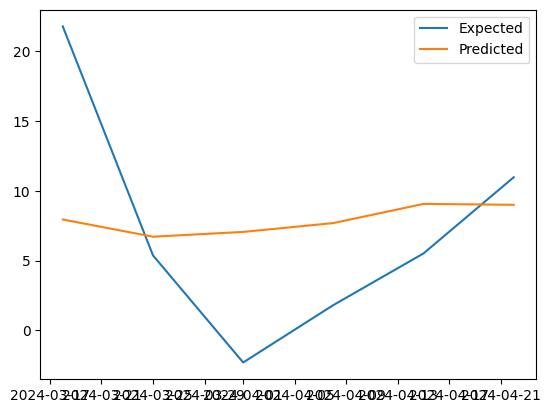

In [38]:
# plot expected vs preducted
plt.plot(df_test['wPreis'], label='Expected')
plt.plot(predicted_test, label='Predicted')
plt.legend()
plt.show()

In [39]:
RandomForest_static = pd.DataFrame([stat_accuracy_prod])
RandomForest_static



,mae,me,rmse,direction_accuracy
0,5.986011,0.718388,7.433007,0.6


In [40]:
%store RandomForest_static

Stored 'RandomForest_static' (DataFrame)


## All other clusters and categories 

In [41]:
# def static_forecast(data):


SyntaxError: incomplete input (1236289035.py, line 1)